# Signs of Smoking: Classifying Smokers Using Biological Health Indicators

Group 005-36: Elena Greenall, Noah Hynds, Dillon Li

### **Introduction**
Despite knowledge that smoking harms nearly every organ in the human body (NIH, 2022), the prevalence of Canadian cigarette smoking in 2020 was 10% (Health Canada, n.d.). Daily smoking has also been associated with increased AST and ALT levels, which are enzymes released in response to liver damage (Jang, 2012). In addition, nicotine increases blood glucose concentration (CDC, 2022), as well as increases triglyceride levels (van der Plas, 2023). As such, the goal of this project will be to use these biological indicators to classify patients based on their probability of being a smoker.  


The question we aim to answer is:<em> can we predict if a patient is a smoker, based on AST level, ALT level, fasting blood sugar level, and triglyceride levels? <em>

We will use the Body Signal of Smoking dataset from <a href ="https://www.kaggle.com/datasets/kukuroo3/body-signal-of-smoking/data"> Kaggle</a>, by Kukuroo3. The dataset contains biological health data of smokers and non-smokers. Due to the number of predictor variables contained within this dataset, we have chosen to focus on AST and ALT levels, fasting blood sugar and triglyceride levels as our research has revealed their relevance to smoking.  

### **Methods**

**Loading, Cleaning and Preprocessing Data**

The first step is to important the necessary libraries for the analysis. 

In [57]:
#import the necessary libraries
library(tidyverse)
library(tidymodels)
library(RColorBrewer)
set.seed(2024)

Next, we load the dataset into Jupyter and add column names. The variables are mutated to the correct data type, and because the dataset contains 55962 points, 1000 points are selected (500 smokers and 500 non-smokers). We create a new dataframe that has only 1000 data points.

In [2]:
#import and clean data
smoking_df <- read.csv("https://raw.githubusercontent.com/egreenall1/dsci100_group_project/main/smoking.csv")
colnames(smoking_df) <- c("ID", "gender","age", "height_cm", "weight_kg", 
                          "waist_cm", "eyesight_left", "eyesight_right", 
                          "hearing_left", "hearing_right", "systolic", 
                          "relaxation", "fasting_blood_sugar", "cholesterol", 
                          "triglyceride", "HDL", "LDL", "hemoglobin", 
                          "urine_protein", "serum_creatine", "AST", 
                          "ALT", "Gtp", "oral", "dental_carries", "tartar", "smoking")
smoking_df <- mutate(smoking_df, smoking = as_factor(smoking))

#the data must be filtered because of the quantity contained in the original set
smoking_smoker_sample <- smoking_df |> filter(smoking == 1) |> slice(1:500)
smoking_nonsmoker_sample <- smoking_df |> filter(smoking == 0) |> slice(1:500)
smoking_df <- rbind(smoking_smoker_sample, smoking_nonsmoker_sample)

We have many predictor variables in our dataset, but we do not want to use all of them. Based on our research, we choose to use AST, ALT, triglyceride and fasting blood sugar levels because these are affected by smoking. 
- Fasting blood sugar: blood sugar after approximately 8-12 hours of not eating
-  Triglyceride: a type of fat found in the bod
- AST: an enzyme released by the liver when damaged
- ALT: an enzyme released by the liver when damaged

Since our smoking_df contains all the variables in the dataset, we must select only our chosen predictors and create a new data frame.ed


In [53]:
#select only the predictors we are interested in
smoking_df <- select(smoking_df, gender, AST, ALT, triglyceride, fasting_blood_sugar, smoking)

#use the head and tail functions to confirm the data has properly been selected without printing the whole dataframe
head(smoking_df, 6)

,gender,AST,ALT,triglyceride,fasting_blood_sugar,smoking
,<chr>,<int>,<int>,<int>,<int>,<fct>
1,M,21,16,182,89,1
2,M,21,27,68,94,1
3,M,21,27,210,112,1
4,M,37,43,318,79,1
5,M,23,19,119,115,1
6,M,29,35,77,87,1


**Table 1:** Smoking data after cleaning and selecting predictors

Since we know we will be using these variables for K-NN analysis, we scale them to ensure that variables with a larger scale do not have a larger effect than variables with a small scale. 

In [45]:
#we scale the variables
smoking_data_scaled <- smoking_df |> 
 mutate(scaled_ALT = scale(ALT, center = TRUE), 
        scaled_AST = scale(AST, center = TRUE),
        scaled_triglyceride = scale(triglyceride, center = TRUE),
        scaled_fasting_blood_sugar = scale(fasting_blood_sugar, center = TRUE))
head(smoking_data_scaled)

,gender,AST,ALT,triglyceride,fasting_blood_sugar,smoking,scaled_ALT,scaled_AST,scaled_triglyceride,scaled_fasting_blood_sugar
,<chr>,<int>,<int>,<int>,<int>,<fct>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>"
1,M,21,16,182,89,1,-0.59632476,-0.3122486,0.7359182,-0.4455933
2,M,21,27,68,94,1,0.07336103,-0.3122486,-0.8566458,-0.2213164
3,M,21,27,210,112,1,0.07336103,-0.3122486,1.1270743,0.5860804
4,M,37,43,318,79,1,1.04744947,0.8206261,2.6358192,-0.8941471
5,M,23,19,119,115,1,-0.41368318,-0.1706393,-0.1441829,0.7206465
6,M,29,35,77,87,1,0.56040525,0.2541888,-0.7309170,-0.5353041


**Table 2:** Smoking data with scaled variables

Using our tidy data, we divide the dataframe into a training and testing set. The training set will be used to train the classifier. We choose a split of 75:25 to ensure the training set has enough observations to create the model, while also making sure we have enough testing data to estimate the prediction accuracy.

In [58]:
#now that the data is clean, we can split the data into training and test data
smoking_split <- initial_split(smoking_data_scaled, prop = 0.75, strata = smoking)  
    smoking_training_data <- training(smoking_split)
    smoking_testing_data <- testing(smoking_split)

Before moving any further with the analysis, we want to make sure that we see differences in the predictors when looking at smokers and nonsmokers. We use the training data to create a summary of our predictors with the group_by and summarize functions.

In [6]:
#now we create a summary of our predictors to see if there are differencs between smokers and non smokers
smoking_summary <- smoking_training_data |> 
    group_by(smoking) |> 
    summarize(mean(AST), mean(ALT), mean(fasting_blood_sugar), mean(triglyceride))

smoking_summary

smoking,mean(AST),mean(ALT),mean(fasting_blood_sugar),mean(triglyceride)
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
0,23.53867,22.66667,96.58933,111.6053
1,27.52267,28.95200,100.78667,145.8960


**Table 3:** Mean values for each predictor 

Based on this table, we see that there are indeed differences in the means of our predictors between smokers (1) and nonsmokers (0). The means of the predictors the smokers are all higher than those of the nonsmokers. *add means*

We now want visualise our predictors to understand if is a relationship. We divide the points into smokers and non-smokers, and also separate the points by gender.

Warning message:
“Removed 4 rows containing missing values or values outside the scale range
(`geom_point()`).”


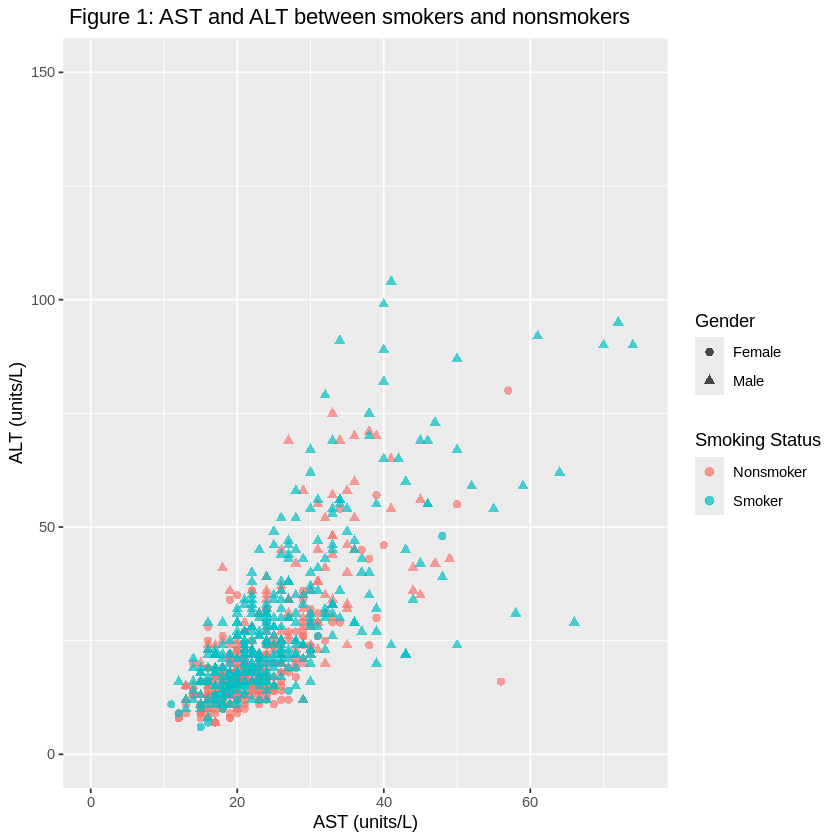

In [55]:
#create a plot of AST vs ALT
smoking_training_plot_AST_ALT <- ggplot(smoking_training_data, aes(x = AST, y = ALT)) + 
    geom_point(alpha = 0.7, aes(color = smoking, shape = gender), size = 2) + 
    labs(x = "AST (units/L)", y = "ALT (units/L)", title = " Figure 1: AST and ALT between smokers and nonsmokers", color = "Smoking Status", shape = "Gender") + 
    xlim(0, 75) + 
    ylim(0, 150) +
    scale_colour_discrete(labels = c("Nonsmoker", "Smoker")) +
    scale_shape_discrete(labels = c("Female", "Male"))
smoking_training_plot_AST_ALT

In Figure 1, we see that smokers and nonsmokers generally have similar AST and ALT levels. Although not many, more smokers appear in the upper right hand corner of the plot, suggesting they have larger values for AST and ALT. Similarly, nonsmokers seem to be concentrated in the lower left hand corner of the plot, suggesting they have lower AST and ALT values.

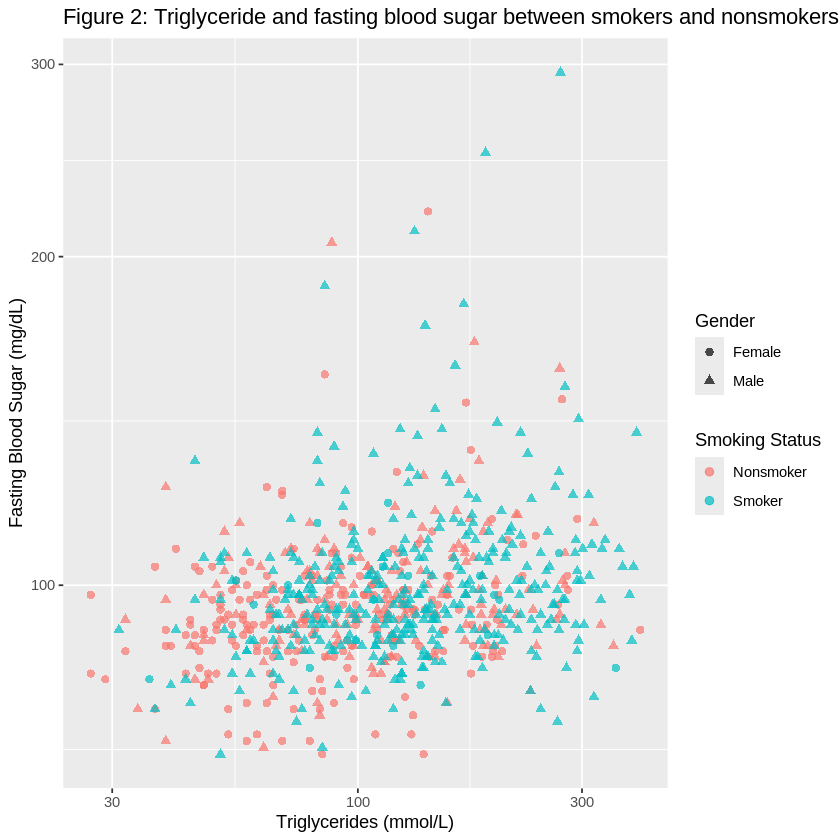

In [56]:
#create a plot of triglycerides vs fasting blood sugar
smoking_training_plot_triglycerides_fasting_blood_sugar <- ggplot(smoking_training_data, aes(x = triglyceride, y = fasting_blood_sugar)) + 
    geom_point(alpha = 0.7, aes(color = smoking, shape = gender), size = 2) + 
    labs(x = "Triglycerides (mmol/L)", y = "Fasting Blood Sugar (mg/dL)", title = "Figure 2: Triglyceride and fasting blood sugar between smokers and nonsmokers", color = "Smoking Status", shape = "Gender") + 
    scale_x_log10() + 
    scale_y_log10() +
    scale_colour_discrete(labels = c("Nonsmoker", "Smoker")) +
    scale_shape_discrete(labels = c("Female", "Male"))

smoking_training_plot_triglycerides_fasting_blood_sugar

In Figure 2, we see that smokers and nonsmokers generally have similar triglyceride and fasting blood sugar levels. More smokers  appear in the right hand corner of the plot, suggesting they haveslightly  arger triglyceride valuesT.

**K-NN Model**

Now that we have cleaned and explored our data, we can start with producing the K-NN model. 

First we prepare a recipe used the predictors that we previously scaled variables. We also center the predictors so there is a mean of 0 and standard deviation of 1. We do not have an issue with class imbalance since we have 500 points for smokers and 500 points for nonsmokers. 

In [70]:
#preparing a recipe using our previously scaled variables 
knn_recipe <- recipe(smoking ~ scaled_AST + scaled_ALT + scaled_triglyceride + scaled_fasting_blood_sugar, data = smoking_training_data) |>
    step_center(all_predictors())

Next, we prepare a K-NN model specification. In this model, the engine must be set to "kknn" and the mode is set to "classification". The function is "rectangular" means that each neighbouring point has the same weight. Since we want to determine the best K value for this model, we use tune(). 

In [60]:
#creating the K-nearest neighbour model
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
    set_engine("kknn") |> 
    set_mode("classification")

Now we tune the model to choose the best K value (the number of neighbours that gives the best accuracy. This is achieved via 5 fold cross validation.

In [62]:
#using vfold_cv to perform 5-fold cross validation on the training data 
vfold <- vfold_cv(smoking_training_data, v = 5, strata = smoking)

values <- tibble(neighbors = seq(from = 150, to = 200, by = 10))

##### the accuracy seems to change based on the by = x?####

Now, we create a workflow using the model and recipe. This will do *what*. We then determine the best K using accuracy in a dataframe. It is organised in descending order so we see the highest accuracy first. 

In [64]:
#creating a workflow to find the best K value 
knn_best <- workflow() |> 
    add_recipe(knn_recipe) |> 
    add_model(knn_spec) |> 
    tune_grid(resamples = vfold, grid = values) |>
#determining accuracy 
    collect_metrics() |> 
    filter(.metric == "accuracy") |>
    select(neighbors, mean) |>
    arrange(desc(mean))

head(knn_best)

neighbors,mean
<dbl>,<dbl>
180,0.6133333
190,0.6093333
200,0.6066667
170,0.6053333
150,0.6013333
160,0.5973333


**Table 4:** Accuracy of different K values

We then also plot each K value against the accuracy.

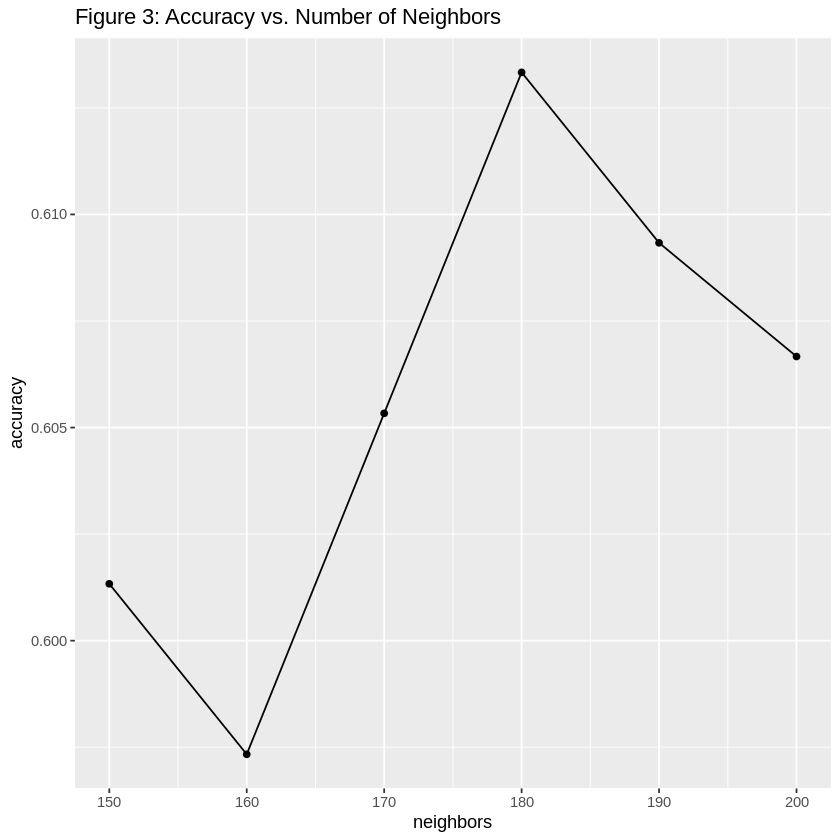

In [65]:
#plotting K versus accuracy 
cross_val_plot <- knn_best |> 
    ggplot(aes(x = neighbors, y = mean)) + 
    geom_point() + 
    geom_line() + 
    labs(x = "neighbors", y = "accuracy", title = "Figure 3: Accuracy vs. Number of Neighbors")
    
cross_val_plot  

Based on Figure 3, we can see that K = x has the highest accuracy, at x%. As such, we use x neighbours for our model. 

Since we now have our most accurate K value, we retrain this model with this K value. This new model is added to the recipe in a workflow. 

In [42]:
set.seed(2024)

#creating a new model with our best K value
best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 190) |> 
    set_engine("kknn") |> 
    set_mode("classification")

#create a workflow our new K value
best_fit <- workflow() |> 
    add_recipe(knn_recipe) |> 
    add_model(best_spec) |> 
    fit(data = smoking_training_data) 
best_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(190,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.4053333
Best kernel: rectangular
Best k: 190

Now we evaluate the model's accuracy using the test data. We use the predict and metrics functions. 

In [67]:
set.seed(2024)

#using predict
smoking_predictions <- predict(best_fit, smoking_testing_data) |> 
    bind_cols(smoking_testing_data) 

#using metrics
smoking_metrics <- smoking_predictions |> 
    metrics(truth = smoking, estimate = .pred_class) |>
    filter(.metric == "accuracy")
smoking_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.636


**Table 5:** Accuracy of the model based on using testing data

Now we create a confusion matrix.

In [66]:
#making a confusion matrix
smoking_conf_mat <- smoking_predictions |> 
    conf_mat(truth = smoking, estimate = .pred_class)
smoking_conf_mat

          Truth
Prediction  0  1
         0 86 52
         1 39 73

**Table 6:** Confusion matrix based on testing data

The classifier was 63.6% accurate and labelled 159/250 observations correctly. The classifier seems more likely to state that a smoker is a non-smoker versus label a non-smoker as a smoker. This is because 52 observations were predicted to be non-smokers, when in reality they are smokers. Conversely, 39 observations were predicted to be smokers, when they are actually non-smokers. The model thus will be more likely to incorrectly classify smokers, which could be concerning if smokers quickly needed to be identified in a medical setting.

### **Discussion**

report the accuracy. 
potential reasons for low accuracy
talk about confusion matrix
improvements for the model
further analysis questionsng?

### **References**

CDC (2022). Smoking and Diabetes. https://www.cdc.gov/diabetes/library/features/smoking-and-diabetes.html#:~:text=How%20Smoking%20Can%20Lead%20to,cells%20stop%20responding%20to%20insulin

Ch, S. R. (2013). The effect of chronic tobacco smoking and chewing on the lipid profile. Journal of clinical and diagnostic research: JCDR, 7(1), 31.

Health Canada (2022). Canadian Tobacco and Nicotine Survey (CTNS): summary of results for 2020. https://www.canada.ca/en/health-canada/services/canadian-tobacco-nicotine-survey/2020-summary.html

Jang, E.S., Jeong, SH., Hwang, S.H. et al. Effects of coffee, smoking, and alcohol on liver function tests: a comprehensive cross-sectional study. BMC Gastroenterol 12, 145 (2012). https://doi.org/10.1186/1471-230X-12-145

NIH (2022). How Smoking Affects the Heart and Blood Vessels. https://www.nhlbi.nih.gov/health/heart/smoking

van der Plas, A., Antunes, M., Pouly, S., de La Bourdonnaye, G., Hankins, M., & Heremans, A. (2023). Meta-analysis of the effects of smoking and smoking cessation on triglyceride levels. Toxicology Reports, 10, 367-375.